In [43]:
import numpy as np
from numpy import mean, std, dstack
from pandas import read_csv
from matplotlib import pyplot as plt, pyplot

import keras
from keras.layers import LSTM
from tensorflow.keras.layers import Activation, MaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Flatten, BatchNormalization, concatenate
from keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# set seed to reproduce similar results
np.random.seed(0)

In [44]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/ex1/uard/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/ex1/uard/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [45]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [46]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


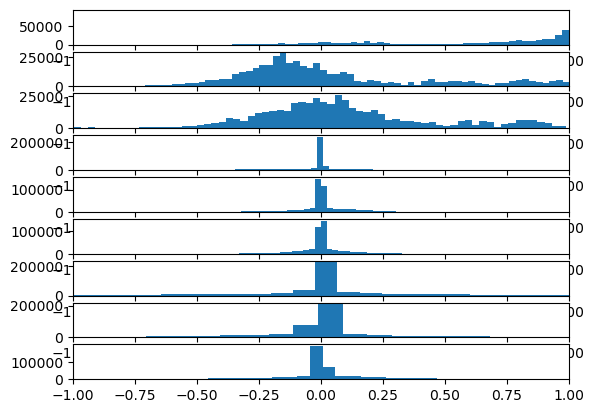

In [47]:
# plot distributions
plot_distributions(trainX)

In [48]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [49]:

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [50]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
92/92 [==============================] - 16s 131ms/step - loss: 1.1541 - accuracy: 0.5186 - val_loss: 0.9279 - val_accuracy: 0.6499
Epoch 2/10
92/92 [==============================] - 12s 126ms/step - loss: 0.7216 - accuracy: 0.7165 - val_loss: 0.7469 - val_accuracy: 0.7655
Epoch 3/10
92/92 [==============================] - 11s 123ms/step - loss: 0.5704 - accuracy: 0.7815 - val_loss: 0.7264 - val_accuracy: 0.8035
Epoch 4/10
92/92 [==============================] - 11s 122ms/step - loss: 0.5239 - accuracy: 0.7895 - val_loss: 0.5593 - val_accuracy: 0.7981
Epoch 5/10
92/92 [==============================] - 11s 123ms/step - loss: 0.3720 - accuracy: 0.8565 - val_loss: 0.5634 - val_accuracy: 0.8226
Epoch 6/10
92/92 [==============================] - 11s 125ms/step - loss: 0.4831 - accuracy: 0.8262 - val_loss: 0.6481 - val_accuracy: 0.8083
Epoch 7/10
92/92 [==============================] - 11s 125ms/step - loss: 0.3164 - accuracy: 0.8883 - val_loss: 0.4764 - val_accuracy: 0.8579

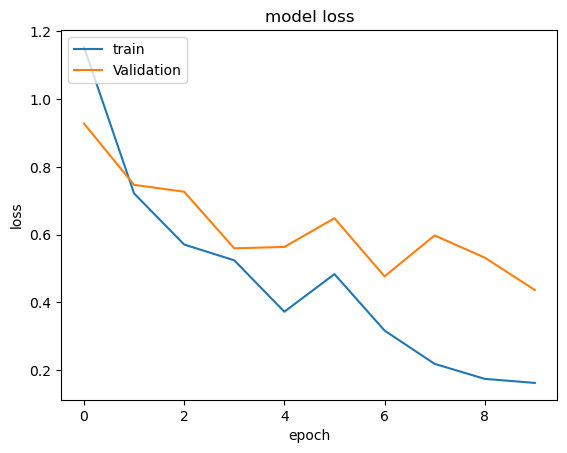

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [52]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BILSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the BILSTM model 0.8775025606155396
93/93 [==============================] - 3s 19ms/step


In [53]:
predictions

array([[1.8525416e-04, 4.6929318e-07, 5.4131141e-07, 5.8198660e-03,
        9.9399334e-01, 5.2133424e-07],
       [1.6477819e-04, 6.7636245e-07, 1.0651213e-06, 1.3284321e-02,
        9.8654765e-01, 1.4840101e-06],
       [1.7445069e-04, 6.7611137e-07, 1.2068240e-06, 1.5290775e-02,
        9.8453134e-01, 1.4856312e-06],
       ...,
       [1.4044727e-02, 9.8548084e-01, 4.1527738e-04, 1.9335687e-06,
        5.0349179e-05, 7.0027386e-06],
       [2.5886022e-02, 9.7010833e-01, 2.5857035e-03, 6.5837412e-05,
        9.1300131e-04, 4.4115554e-04],
       [9.1132792e-03, 9.8980755e-01, 8.9378556e-04, 5.1385632e-06,
        1.2717502e-04, 5.3038810e-05]], dtype=float32)

**** Confusion Matrix ****
[[454   9  32   0   1   0]
 [ 80 370  21   0   0   0]
 [  9   1 410   0   0   0]
 [  0   0   0 413  78   0]
 [ 10   2   0 101 419   0]
 [  0   1   0   0  16 520]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.82      0.92      0.87       496
           2       0.97      0.79      0.87       471
           3       0.89      0.98      0.93       420
           4       0.80      0.84      0.82       491
           5       0.82      0.79      0.80       532
           6       1.00      0.97      0.98       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



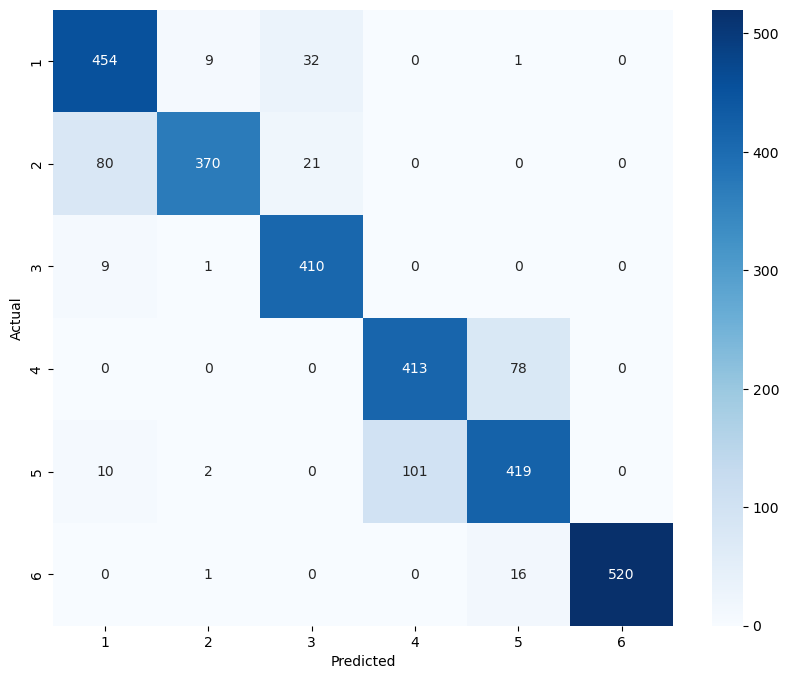

In [54]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)